In [1]:
import numpy as np
import pandas as pd
import time

import random

import matplotlib
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm

#import pickle5 as pickle

from IPython import display
%matplotlib inline

import matplotlib.ticker as tick

import sys
sys.path.append('..')
from nsgp_vi import nsgpVI
# We'll use double precision throughout for better numerics.
dtype = np.float64


from addons.gradient_accumulator import GradientAccumulator

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

plt.style.use('ggplot') 
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid') 
#v3 i.e. version 3, given by the new way(third way) of calculating the batches

In [2]:
# class GradientAccumulator(object):
#     """Gradient accumulation utility.

#     When used with a distribution strategy, the accumulator should be called in a
#     replica context. Gradients will be accumulated locally on each replica and
#     without synchronization. Users should then call ``.gradients``, scale the
#     gradients if required, and pass the result to ``apply_gradients``.
#     """

#     # We use the ON_READ synchronization policy so that no synchronization is
#     # performed on assignment. To get the value, we call .value() which returns the
#     # value on the current replica without synchronization.

#     def __init__(self):
#         """Initializes the accumulator."""
#         self._gradients = []
#         self._accum_steps = None

#     @property
#     def step(self):
#         """Number of accumulated steps."""
#         if self._accum_steps is None:
#             self._accum_steps = tf.Variable(
#                 tf.constant(0, dtype=tf.int64),
#                 trainable=False,
#                 synchronization=tf.VariableSynchronization.ON_READ,
#                 aggregation=tf.VariableAggregation.ONLY_FIRST_REPLICA,
#             )
#         return self._accum_steps.value()

#     @property
#     def gradients(self):
#         """The accumulated gradients on the current replica."""
#         if not self._gradients:
#             raise ValueError(
#                 "The accumulator should be called first to initialize the gradients"
#             )
#         grads = list(gradient.value()/tf.cast(self._accum_steps, gradient.dtype) for gradient in self._gradients)
#         clipped_grads, gn = tf.clip_by_global_norm(grads,clip_norm=1.0)
#         return clipped_grads
    
    

#     def __call__(self, gradients):
#         """Accumulates :obj:`gradients` on the current replica."""
#         if not self._gradients:
#             _ = self.step  # Create the step variable.
#             self._gradients.extend(
#                 [
#                     tf.Variable(
#                         tf.zeros_like(gradient),
#                         trainable=False,
#                         synchronization=tf.VariableSynchronization.ON_READ,
#                     )
#                     for gradient in gradients
#                 ]
#             )
#         if len(gradients) != len(self._gradients):
#             raise ValueError(
#                 "Expected %s gradients, but got %d"
#                 % (len(self._gradients), len(gradients))
#             )

#         for accum_gradient, gradient in zip(self._gradients, gradients):
#             accum_gradient.assign_add(gradient, read_value=False)
#         self._accum_steps.assign_add(1)

#     def reset(self):
#         """Resets the accumulated gradients on the current replica."""
#         if not self._gradients:
#             return
#         self._accum_steps.assign(0)
#         for gradient in self._gradients:
#             gradient.assign(
#                 tf.zeros(gradient.shape, dtype=gradient.dtype), read_value=False
#             )


In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

In [25]:
df = pd.read_csv('../data/ns_synthetic_data_indv_8.csv')
T = df['Time'].values[:,None]
ID = df['ID'].values
X = np.array(df['observations']).reshape(len(T),1)
true_len = np.array(df['Lengthscale']).reshape(len(T),1)
true_var = np.array(df['Variance']).reshape(len(T),1)

In [26]:
#T_ = tf.convert_to_tensor(T, dtype=tf.float64)
#X_ = tf.convert_to_tensor(X, dtype=tf.float64)
num_training_points_ = T.shape[0]

num_inducing_points_ = 50
#inducing_index_points = np.random.uniform(0.0,60*24.,size=num_inducing_points_)[..., np.newaxis]#np.linspace(0., 60*24., num_inducing_points_, endpoint=False)[..., np.newaxis]
inducing_index_points = np.linspace(0., 60*24., num_inducing_points_, endpoint=False)[..., np.newaxis]

np.random.shuffle(inducing_index_points)
#x_train_ = T_ # observation_index_points i.e. the time index points
#inducing_index_points
#y_train_ = X_ #observations i.e. data X, the original positions


#kernel_amp = tfk.Linear(bias_variance=np.float64(0.0), slope_variance=np.float64(0.0))

In [6]:

# BATCH_SIZE=2
# SEG_LENGTH=1024

# allT = []
# allX = []
# for i in np.unique(df['ID'].values):
#     allT.append(df['Time'][df['ID'].values == i].values[...,None])
#     allX.append(df['observations'][df['ID'].values == i].values[...,None])


# def get_generator(T,X):
#     def segment_generator():
#         rand_start = np.random.randint(T.shape[0])
#         max_index = T.shape[0]
#         if rand_start+SEG_LENGTH>max_index:
#             jj = np.arange(max_index-SEG_LENGTH,max_index)
#         else:
#             jj = np.arange(rand_start,rand_start+SEG_LENGTH)
            
        
#         yield np.reshape(np.take(T,jj,mode='wrap',axis=0),(SEG_LENGTH,T.shape[-1])), \
#                 np.reshape(np.take(X,jj,mode='wrap',axis=0),(SEG_LENGTH,X.shape[-1]))

#     return segment_generator

# inner_dataset = [tf.data.Dataset.from_generator(get_generator(TT,XX), (tf.float64)) for TT,XX in zip(allT,allX)]


# dataset = tf.data.experimental.sample_from_datasets(inner_dataset)
# dataset = dataset.map(lambda dd: (dd[0],dd[1]))

# dataset = dataset.shuffle(len(inner_dataset), reshuffle_each_iteration=True)
# dataset = dataset.batch(BATCH_SIZE)

# dataset = dataset.repeat(2)





In [7]:
#num_training_points_//len(allT)/SEG_LENGTH

In [8]:
BATCH_SIZE=8
SEG_LENGTH=1024

allT = []
allX = []
for i in np.unique(df['ID'].values):
    allT.append(df['Time'][df['ID'].values == i].values[...,None])
    allX.append(df['observations'][df['ID'].values == i].values[...,None])

class segment_generator:
    def __iter__(self):
        self.i = 0
        self.max_i = len(allT)
        
        self.i_list = np.arange(0,self.max_i)
        np.random.shuffle(self.i_list)
        
        self.samples_per_epoch = num_training_points_//(self.max_i*SEG_LENGTH)
        
        self.loop_count = 0
        
        return self

    def __next__(self):
        
        if self.i == self.max_i:
            self.i = 0
            self.loop_count+=1
            self.i_list = np.arange(0,self.max_i)
            np.random.shuffle(self.i_list)
            if self.samples_per_epoch==self.loop_count:
                raise StopIteration
            
        T = allT[self.i_list[self.i]]
        X = allX[self.i_list[self.i]]

        index = np.random.randint(T.shape[0])
        max_index = T.shape[0]
        index = min(index,max_index-SEG_LENGTH)


        TT = T[index:index+SEG_LENGTH]
        XX = X[index:index+SEG_LENGTH]
    
        self.i += 1

        return TT,XX

        
dataset = tf.data.Dataset.from_generator(segment_generator, (tf.float64)) 
dataset = dataset.map(lambda dd: (dd[0],dd[1]))
dataset = dataset.batch(BATCH_SIZE)
d_size = T.shape[0]//SEG_LENGTH//(BATCH_SIZE)

In [27]:
BATCH_SIZE=8
SEG_LENGTH=1024

allT = []
allX = []
for i in np.unique(df['ID'].values):
    allT.append(df['Time'][df['ID'].values == i].values[...,None])
    allX.append(df['observations'][df['ID'].values == i].values[...,None])

class segment_generator:
    def __iter__(self):
        
        # loop over individuals
        self.i = 0
        self.max_i = len(allT)
        
        # loop over segments
        self.j = 0
        self.max_j = num_training_points_//(self.max_i*SEG_LENGTH)
        
        
        
        return self

    def __next__(self):
        
        if self.i == self.max_i:
            self.i = 0
            self.j +=1
            if self.j==self.max_j:
                raise StopIteration
            
        T = allT[self.i]
        X = allX[self.i] 

        

        TT = T[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
        XX = X[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
    
        self.i += 1

        return TT,XX

        
dataset = tf.data.Dataset.from_generator(segment_generator, (tf.float64)) 
dataset = dataset.map(lambda dd: (dd[0],dd[1]))
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE)
d_size = T.shape[0]//SEG_LENGTH//(BATCH_SIZE)

In [28]:
d_size

8

In [29]:

for d in dataset:
    print(d[0].shape)


(8, 1024, 1)
(8, 1024, 1)
(8, 1024, 1)
(8, 1024, 1)
(8, 1024, 1)
(8, 1024, 1)
(8, 1024, 1)
(8, 1024, 1)


In [34]:
kernel_len_a = tfp.util.TransformedVariable(2.0, tfb.Softplus(),dtype=tf.float64, name='k_len_a',trainable=True)
kernel_len_l = tfp.util.TransformedVariable(30.0,tfb.Softplus(),dtype=tf.float64, name='k_len_l',trainable=True)

# amplitude kernel parameters, lower levels
kernel_amp_a = tfp.util.TransformedVariable(2.0, tfb.Softplus(), dtype=tf.float64, name='k_amp_a',trainable=True)
kernel_amp_l = tfp.util.TransformedVariable(30.0,tfb.Softplus(), dtype=tf.float64, name='k_amp_l',trainable=True)

    #kernels on the second layer
kernel_len = tfk.ExponentiatedQuadratic(kernel_len_a,kernel_len_l)
kernel_amp = tfk.ExponentiatedQuadratic(kernel_amp_a,kernel_amp_l)

vgp = nsgpVI(kernel_len,kernel_amp,n_inducing_points=num_inducing_points_,inducing_index_points=inducing_index_points,dataset=dataset,num_training_points=num_training_points_, num_sequential_samples=10,num_parallel_samples=10,init_observation_noise_variance=0.005**2)  


In [35]:
#loss = vgp.warm_up_optimize(BATCH_SIZE, SEG_LENGTH, NUM_EPOCHS=10)
 


In [ ]:
loss = vgp.optimize(BATCH_SIZE, SEG_LENGTH, NUM_EPOCHS=500)


Loss 6849.464130:   1%|          | 3/500 [02:01<5:14:15, 37.94s/it]  

In [16]:


# initial_learning_rate = float(BATCH_SIZE*SEG_LENGTH)/float(vgp.num_training_points)

# steps_per_epoch = vgp.num_training_points//(BATCH_SIZE*SEG_LENGTH)
# learning_rate = tf.optimizers.schedules.ExponentialDecay(
# initial_learning_rate=initial_learning_rate,
#     decay_steps=steps_per_epoch,
#     decay_rate=0.95,
#     staircase=True)

# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,global_clipnorm=1.0)
# accumulator = GradientAccumulator()#optimizer, accum_steps=vgp.num_sequential_samples, reduction='MEAN')


# warmup_variables = [vgp.len_variational_inducing_observations_loc, vgp.amp_variational_inducing_observations_loc]
# #self.len_variational_inducing_observations_scale.variables[0]._trainable=False
# #self.amp_variational_inducing_observations_scale.variables[0]._trainable=False

# @tf.function
# def warmup_train_step(x_train_batch, y_train_batch):

#     kl_weight = tf.reduce_sum(tf.ones_like(x_train_batch))/vgp.num_training_points

#     with tf.GradientTape(watch_accessed_variables=True) as tape:
#         # Create the loss function we want to optimize.
#         loss = vgp.variational_loss(observations=y_train_batch,observation_index_points=x_train_batch,kl_weight=kl_weight) 
#     grads = tape.gradient(loss, warmup_variables)
#     accumulator(grads)
#     return loss, grads


# @tf.function
# def apply_grads():
#     grads = accumulator.gradients
#     optimizer.apply_gradients(zip(grads, warmup_variables))
#     accumulator.reset()
#     return 


# for i in range(2):
#     for batch in dataset:
#         print(batch[0].shape)
#         batch_loss=0
#         for s in range(vgp.num_sequential_samples):
#             print(s,'-----------------------------')
#             print( (s+1)%vgp.num_sequential_samples==0)
#             loss, grads = warmup_train_step(*batch)
            
#             print(accumulator.gradients[0].numpy())
#             if (s+1)%vgp.num_sequential_samples==0:
#                 apply_grads()
                
#             print('l', loss.numpy())

#             batch_loss += loss.numpy()
#             batch_loss/=vgp.num_sequential_samples

#             print('bl', batch_loss)
#             print('grads', grads[0].numpy()[0])
#             print('p1', vgp.len_variational_inducing_observations_loc.numpy()[0])
    

In [28]:
# def loss_calc(x_train_batch, y_train_batch):
    
#     kl_weight = tf.reduce_sum(tf.ones_like(x_train_batch))/num_training_points_

#     loss = vgp.variational_loss(observations=y_train_batch,observation_index_points=x_train_batch,kl_weight=kl_weight)
#     return loss

# num_sequential_samples=1
# for i in range(10):
    
#     batch_loss = 0.0    
#     for batch in dataset:
#         for s in range(num_sequential_samples):
#             loss = loss_calc(*batch)
#             batch_loss += loss.numpy()
#         batch_loss/=num_sequential_samples
#     print(batch_loss)

7988.20493259996
7988.461248833662
7989.809819359744
7993.225685605873
7987.583650562406
7988.979490207065
7992.991808464663
7993.0005066719905
7990.325408598172
7988.539718227381


In [ ]:
plt.plot(loss[0:])
plt.show()

In [ ]:

ZZ = np.linspace(0,24*60,200)[:,None]

len_mean, len_var = vgp.get_len_cond(ZZ[None,...],full_cov=False)
len_mean = len_mean[0,:,0].numpy()
len_std = len_var[:,0].numpy()**0.5



amp_mean, amp_var = vgp.get_amp_cond(ZZ[None,...],full_cov=False)
amp_mean = amp_mean[0,:,0].numpy()
amp_std = amp_var[:,0].numpy()**0.5


# for i in range(S):
#     plt.plot(ZZ,len_vals[i],color='C0',alpha=0.01)
# #plt.plot(T,true_len,'.',markersize=1,color='blue')
# plt.plot(vgp.len_inducing_index_points.numpy(), np.ones_like(vgp.len_inducing_index_points.numpy()),'o')


f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))


ax1.plot(ZZ,tf.math.softplus(vgp.mean_len + len_mean),color='C1')

ax1.fill_between(ZZ[:,0],tf.math.softplus(vgp.mean_len + len_mean - 1.96*len_std),tf.math.softplus(vgp.mean_len + len_mean + 1.96*len_std),color='C1',alpha=0.5)
#ax1.plot(T,true_len,'.',markersize=1,color='red')
ax1.plot(T[:8192],true_len[:8192],'--',markersize=1,color='k',alpha=0.5)


ax2.plot(T[:8192],true_var[:8192],'--',markersize=1,color='k',alpha=0.5)
ax2.plot(ZZ,tf.math.softplus(vgp.mean_amp + amp_mean),color='C1')

ax2.fill_between(ZZ[:,0],tf.math.softplus(vgp.mean_amp + amp_mean - 1.96*amp_std),tf.math.softplus(vgp.mean_amp + amp_mean + 1.96*amp_std),color='C1',alpha=0.5)

plt.show()
# plt.plot(ZZ,tf.math.softplus(vgp.mean_amp + amp_mean[0]+amp_var[:,0]**0.5),co

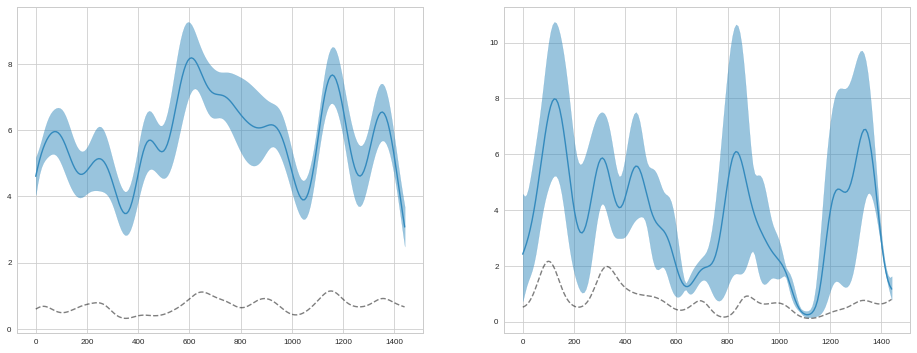

In [8]:

ZZ = np.linspace(0,24*60,200)[:,None]

len_mean, len_var = vgp.get_len_cond(ZZ[None,...],full_cov=False)
len_mean = len_mean[0,:,0].numpy()
len_std = len_var[:,0].numpy()**0.5



amp_mean, amp_var = vgp.get_amp_cond(ZZ[None,...],full_cov=False)
amp_mean = amp_mean[0,:,0].numpy()
amp_std = amp_var[:,0].numpy()**0.5


# for i in range(S):
#     plt.plot(ZZ,len_vals[i],color='C0',alpha=0.01)
# #plt.plot(T,true_len,'.',markersize=1,color='blue')
# plt.plot(vgp.len_inducing_index_points.numpy(), np.ones_like(vgp.len_inducing_index_points.numpy()),'o')


f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))


ax1.plot(ZZ,tf.math.softplus(vgp.mean_len + len_mean),color='C1')

ax1.fill_between(ZZ[:,0],tf.math.softplus(vgp.mean_len + len_mean - 1.96*len_std),tf.math.softplus(vgp.mean_len + len_mean + 1.96*len_std),color='C1',alpha=0.5)
#ax1.plot(T,true_len,'.',markersize=1,color='red')
ax1.plot(T[:8192],true_len[:8192],'--',markersize=1,color='k',alpha=0.5)


ax2.plot(T[:8192],true_var[:8192],'--',markersize=1,color='k',alpha=0.5)
ax2.plot(ZZ,tf.math.softplus(vgp.mean_amp + amp_mean),color='C1')

ax2.fill_between(ZZ[:,0],tf.math.softplus(vgp.mean_amp + amp_mean - 1.96*amp_std),tf.math.softplus(vgp.mean_amp + amp_mean + 1.96*amp_std),color='C1',alpha=0.5)

plt.show()

In [ ]:
vgp.len_variational_inducing_observations_scale.variables[0]._trainable=False
vgp.amp_variational_inducing_observations_scale.variables[0]._trainable=False

In [ ]:
# NUM_EPOCHS=1000 # 8 training
warmup_variables = tuple([list(vgp.kernel_amp.trainable_variables)+list(vgp.kernel_len.trainable_variables)+[vgp.len_variational_inducing_observations_loc, vgp.amp_variational_inducing_observations_loc]])
NUM_EPOCHS=500 # 128 training

initial_learning_rate = float(BATCH_SIZE*SEG_LENGTH)/float(num_training_points_)

steps_per_epoch = num_training_points_//(BATCH_SIZE*SEG_LENGTH)
learning_rate = tf.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=0.95,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
optimizer = GradientAccumulator(optimizer, accum_steps=10, reduction='MEAN')


#@tf.function
def optimize(x_train_batch, y_train_batch):
    
    kl_weight = tf.reduce_sum(tf.ones_like(x_train_batch))/num_training_points_

    with tf.GradientTape(watch_accessed_variables=True) as tape:
        # Create the loss function we want to optimize.
        loss = vgp.variational_loss(observations=y_train_batch,observation_index_points=x_train_batch,kl_weight=kl_weight)
    grads = tape.gradient(loss, *warmup_variables)
    optimizer.apply_gradients(zip(grads, *warmup_variables))
    return loss

#pbar = tqdm(range(NUM_EPOCHS))
loss_history = np.zeros((NUM_EPOCHS))

for i in range(NUM_EPOCHS):
    
    lnp = 0.0
    for batch in dataset:
    #batch = next(iter(dataset))
        for s in range(10):

            loss = optimize(*batch)
        lnp += loss.numpy()
    
#     vgp.len_variational_inducing_observations_scale.variables[0]._trainable=True
#     vgp.amp_variational_inducing_observations_scale.variables[0]._trainable=True
#     try:
#         ZZ = np.linspace(0,24*60,200)[:,None]

#         len_mean, len_var = vgp.get_len_cond(ZZ[None,...],full_cov=False)
#         len_mean = len_mean[0,:,0].numpy()
#         len_std = len_var[:,0].numpy()**0.5



#         amp_mean, amp_var = vgp.get_amp_cond(ZZ[None,...],full_cov=False)
#         amp_mean = amp_mean[0,:,0].numpy()
#         amp_std = amp_var[:,0].numpy()**0.5


#         # for i in range(S):
#         #     plt.plot(ZZ,len_vals[i],color='C0',alpha=0.01)
#         # #plt.plot(T,true_len,'.',markersize=1,color='blue')
#         # plt.plot(vgp.len_inducing_index_points.numpy(), np.ones_like(vgp.len_inducing_index_points.numpy()),'o')


#         # plt.show()
#         plt.close()
#         plt.clf()
#         f, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,12))

       
#         ax1.plot(ZZ,tf.math.softplus(vgp.mean_len + len_mean),color='C1')

#         ax1.fill_between(ZZ[:,0],tf.math.softplus(vgp.mean_len + len_mean - 1.96*len_std),tf.math.softplus(vgp.mean_len + len_mean + 1.96*len_std),color='C1',alpha=0.5)
#         ax1.plot(T,true_len,'.',markersize=1,color='red')
        
        
#         ax2.plot(ZZ,tf.math.softplus(vgp.mean_amp + amp_mean),color='C1')

#         ax2.fill_between(ZZ[:,0],tf.math.softplus(vgp.mean_amp + amp_mean - 1.96*amp_std),tf.math.softplus(vgp.mean_amp + amp_mean + 1.96*amp_std),color='C1',alpha=0.5)
#         ax2.plot(T,true_var,'.',markersize=1,color='red')
#         display.display(plt.gcf())
#         display.clear_output(wait=True)
#         #time.sleep(1)
#     except KeyboardInterrupt:
#         break

#     #pbar.set_description("Loss %f" % lnp)

#     loss_history[i] = lnp

In [ ]:

S=1000
ZZ = np.linspace(0,24*60,200)[:,None]
ZZ.shape
len_vals = tf.squeeze(vgp.get_len_samples(ZZ[None,...],S))
amp_vals = tf.squeeze(vgp.get_amp_samples(ZZ[None,...],S))


for i in range(S):
    plt.plot(ZZ,len_vals[i],color='C0',alpha=0.01)
plt.plot(T,true_len,'.',markersize=1,color='blue')

plt.show()

for i in range(S):
    plt.plot(ZZ,amp_vals[i],color='C0',alpha=0.01)
plt.plot(T,true_var,'.',markersize=1,color='blue')

plt.show()

In [ ]:
len_mean, len_var = vgp.get_len_cond(ZZ[None,...],full_cov=False)
len_mean = len_mean[0,:,0].numpy()
len_std = len_var[:,0].numpy()**0.5



amp_mean, amp_var = vgp.get_amp_cond(ZZ[None,...],full_cov=False)
amp_mean = amp_mean[0,:,0].numpy()
amp_std = amp_var[:,0].numpy()**0.5


# for i in range(S):
#     plt.plot(ZZ,len_vals[i],color='C0',alpha=0.01)
# #plt.plot(T,true_len,'.',markersize=1,color='blue')
# plt.plot(vgp.len_inducing_index_points.numpy(), np.ones_like(vgp.len_inducing_index_points.numpy()),'o')


# plt.show()


plt.plot(ZZ,tf.math.softplus(vgp.mean_len + len_mean),color='C1')

plt.fill_between(ZZ[:,0],tf.math.softplus(vgp.mean_len + len_mean - 1.96*len_std),tf.math.softplus(vgp.mean_len + len_mean + 1.96*len_std),color='C1',alpha=0.5)
plt.plot(T,true_len,'.',markersize=1,color='red')

plt.show()


plt.plot(ZZ,tf.math.softplus(vgp.mean_amp + amp_mean),color='C1')

plt.fill_between(ZZ[:,0],tf.math.softplus(vgp.mean_amp + amp_mean - 1.96*amp_std),tf.math.softplus(vgp.mean_amp + amp_mean + 1.96*amp_std),color='C1',alpha=0.5)
plt.plot(T,true_var,'.',markersize=1,color='red')
#plt.ylim(0,1)
plt.show()
# plt.plot(ZZ,tf.math.softplus(vgp.mean_amp + amp_mean[0]+amp_var[:,0]**0.5),co

In [ ]:
vgp.trainable_variables

In [17]:
vgp.trainable_variables

(<tf.Variable 'amp_ind_loc_post:0' shape=(50,) dtype=float64, numpy=
 array([ 2.56742319, 12.56837186, -1.60822239,  6.34368198,  7.01996387,
         1.76923386,  1.93917928,  5.64467081, 11.87875928, -5.85688486,
         1.87915253,  6.49277396,  1.62041018, -4.1178695 , -5.70957427,
         1.84621574,  1.10746342, -0.39187731, -1.23806336,  5.98844523,
         2.54262518,  0.84318733, -8.87973948,  2.54642567,  4.01030394,
         4.93230247, -1.94634184,  3.64475959,  5.76208168, -4.38105634,
        -5.69905297,  0.9017249 , -3.599063  ,  3.89968202, -6.08862748,
         5.0648298 , -0.26530513, -0.25463385, -0.19745746, -0.89668334,
         0.93143125,  1.71166265, -0.44577316, -0.17470821, -0.19927841,
        -0.03972601, -0.04368218, -0.17520966, -0.06428954,  0.02672417])>,
 <tf.Variable 'len_ind_loc_post:0' shape=(50,) dtype=float64, numpy=
 array([ 9.68709204e+00, -6.04838900e+00,  5.43397107e+00, -3.76873896e+00,
        -5.70606729e+00,  9.69300632e+00,  7.55622755

In [ ]:
vgp.len_variational_inducing_observations_scale#.Trainable=True
vgp.amp_variational_inducing_observations_scale.variables[0]._trainable=True# pretransformed_input.trainable=True# Trainable # .Trainable

In [ ]:
list(vgp.kernel_amp.trainable_variables)+list(vgp.kernel_len.trainable_variables)+[vgp.len_variational_inducing_observations_loc, vgp.amp_variational_inducing_observations_loc]